In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from numpy import array, newaxis, expand_dims

Using TensorFlow backend.


In [2]:
%run functions.py

In [3]:
path="/home/seo/ISIC DATA/"
process_path='/home/seo/jupyter/Capstone2'
filelist=os.listdir(path)
processfiles=os.listdir(process_path)
meta=[file for file in filelist if not file.endswith(".jpeg") and not file.endswith(".png") and file.startswith("ISIC")]
pics=[file for file in filelist if (file.endswith(".jpeg") or file.endswith(".png")) and file.startswith("ISIC")]

In [4]:
import pickle
model=pickle.load(open('model_fitted.pickle',"rb"))

W0729 07:17:45.299350 140683319752512 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 07:17:45.325484 140683319752512 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0729 07:17:45.358551 140683319752512 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 07:17:45.359792 140683319752512 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated

In [5]:
# Set some parameters
im_width = 128
im_height = 128
img_channels=3
images = np.zeros((len(pics),im_height, im_width, 1), dtype=np.float32)

/home/seo/environments/my_env/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


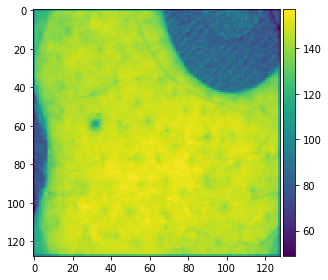

In [86]:
test_img=call_image(test)
test2=resize(test_img, (128, 128, 1), mode = 'constant', 
                  preserve_range = True)
imshow(array_resize(test_img).squeeze())
imshow(test2.squeeze())

for every picture
call image
denoise
resize
apply mask to get only lesion
have label as dictionary key
save every 2000 pictures

In [6]:
def save_as_chunk(save_dict,label,number,chunksize=2000):
    if len(save_dict)%(chunksize-1)==0:
        save_name='{}_{}.p'.format(label,number)
        pickle.dump(save_dict, open(save_name,"wb"))
        del save_dict
        save_dict=dict()

In [7]:
i=0
resized_dict=dict()
orig_dict=dict()
for pic_name in pics:
    name=path+pic_name
    label=pic_name.split('.')[0]
   # tag0="orig"
    tag1="resized"
    img=call_image(name)
    #resize_orig=resize(img, (128, 128, 1), mode = 'constant', 
     #                  preserve_range = True)
    denoised_img=denoise(img)
    resized=array_resize(denoised_img)
    resized_dict[label]=resized
    #orig_dict[label]=resized_orig
    if len(resized_dict)%1999==0:
        i+=1
        save_name1='{}_{}.p'.format(tag1,i)
        pickle.dump(resized_dict, open(save_name1,"wb"))
        del resized_dict
        resized_dict=dict()
        #orig_dict=dict()
resized_files=[file for file in processfiles if file.split('_')[0]==tag1]
#orig_files=[file for file in processfiles if file.split('_')[0]==tag0]


In [8]:
i=0
pred_dict=dict()
for chunk in resized_files:
    resized_dict_open=pickle.load(open(chunk,'rb'))
    for key in resized_dict_open.keys():
        tag2="pred"
        img=resized_dict_open[key]
        _,pred = prediction(model,img)
        mask=mask_w_predicted(pred)
        pred_dict[key]=mask
        if len(resized_dict)%10==0:
            i+=1
            save_name2='{}_{}.p'.format(tag2,i)
            pickle.dump(pred_dict, open(save_name2,"wb"))
            del pred_dict
            pred_dict=dict()
pred_files=[file for file in processfiles if file.split('_')[0]==tag2]

In [9]:
i=0
cont_dict=dict()
seg_dict=dict()
for chunk in pred_files:
    pred_dict_open=pickle.load(open(chunk,'rb'))
    for key in pred_dict_open.keys():
        tag3="segm"
        tag4="cont"
        mask=pred_dict_open[key]
        try:
            cnts,h=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE )
            contour=cnts[0]
        except:
            continue
        try:
            M = cv2.moments(contour)
            (a,b),(MA,ma),angle = cv2.fitEllipse(contour)
        except:
            continue
        cont_dict[key]=[cnts[0],angle,int(a),int(b)]    
        
        orig_img=call_image(path+key+'.jpeg')
        resized_orig=resize(orig_img, (128, 128, 1), mode = 'constant', 
                            preserve_range = True)
        dst = cv2.bitwise_and(resized_orig, resized_orig, mask=mask)
        
        seg_dict[key]=dst
        if len(cont_dict)%10==0:
            i+=1
            save_name3='{}_{}.p'.format(tag3,i)
            save_name4='{}_{}.p'.format(tag4,i)
            pickle.dump(cont_dict, open(save_name3,"wb"))
            pickle.dump(seg_dict, open(save_name4,"wb"))
            del pred_dict
            cont_dict=dict()
            seg_dict=dict()


In [56]:
seg_dict=pickle.load(open('resized_1.p','rb'))
seg_dict2=pickle.load(open('resized_0.p','rb'))

In [57]:
seg_dict2

{'ISIC_0003525': array([[[[0.41769266],
          [0.49389536],
          [0.49504818],
          ...,
          [0.22591652],
          [0.22778468],
          [0.19770922]],
 
         [[0.48852452],
          [0.57557529],
          [0.578618  ],
          ...,
          [0.25245216],
          [0.25083365],
          [0.22895359]],
 
         [[0.48988328],
          [0.57607281],
          [0.58108131],
          ...,
          [0.24730496],
          [0.25254741],
          [0.22768581]],
 
         ...,
 
         [[0.4902816 ],
          [0.57682407],
          [0.58146179],
          ...,
          [0.63137205],
          [0.60967861],
          [0.5105385 ]],
 
         [[0.48783711],
          [0.57524048],
          [0.57291757],
          ...,
          [0.62290098],
          [0.60015637],
          [0.50786824]],
 
         [[0.42009153],
          [0.49301095],
          [0.48926262],
          ...,
          [0.52695893],
          [0.51038681],
          [0.44046688]]

In [58]:
seg_dict

{'ISIC_0002698': array([[[[0.38681534],
          [0.44230843],
          [0.45288753],
          ...,
          [0.5695839 ],
          [0.55342978],
          [0.46828888]],
 
         [[0.44647823],
          [0.52046943],
          [0.53006583],
          ...,
          [0.6775702 ],
          [0.6537336 ],
          [0.54490288]],
 
         [[0.44347121],
          [0.52881947],
          [0.52910788],
          ...,
          [0.69787279],
          [0.66742317],
          [0.54670867]],
 
         ...,
 
         [[0.44875947],
          [0.54131615],
          [0.55251849],
          ...,
          [0.58491584],
          [0.56629621],
          [0.48774912]],
 
         [[0.43591598],
          [0.52886342],
          [0.54485385],
          ...,
          [0.57038462],
          [0.56924715],
          [0.48656744]],
 
         [[0.372731  ],
          [0.44192068],
          [0.46070099],
          ...,
          [0.47974943],
          [0.49070973],
          [0.40940155]]